SIFT + RANSAC

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

In [13]:
# Step 1: Load and resize images
def load_images(max_size=1000):
    """Load, resize, and validate four overlapping images."""
    paths = [
        r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im1.jpg',
        r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im2.jpg',
        r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im3.jpg',
        r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im4.jpg'
    ]
    images = []
    for path in paths:
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        # Resize image to keep max dimension <= max_size
        h, w = img.shape[:2]
        scale = min(max_size / w, max_size / h, 1.0)
        if scale < 1.0:
            img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
        images.append(img)
    gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
    
    # Visualize input images
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(images, 1):
        plt.subplot(2, 2, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f'Image {i}')
        plt.axis('off')
    plt.suptitle('Input Images')
    plt.tight_layout()
    plt.savefig(r'D:\University\Computer_vision\CV\Midterm\data\output\part_c\input_images.png')
    plt.show()
    
    return images, gray_images

In [14]:
# Step 2: SIFT feature detection
def detect_sift_features(gray_images, contrast_threshold=0.04, edge_threshold=10):
    """Detect SIFT keypoints and descriptors."""
    sift = cv2.SIFT_create(contrastThreshold=contrast_threshold, edgeThreshold=edge_threshold)
    keypoints_list, descriptors_list, keypoints_images = [], [], []
    for i, gray_img in enumerate(gray_images):
        keypoints, descriptors = sift.detectAndCompute(gray_img, None)
        keypoints_list.append(keypoints)
        descriptors_list.append(descriptors)
        keypoint_img = cv2.drawKeypoints(
            gray_img, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )
        keypoints_images.append(keypoint_img)
        print(f"Image {i+1}: Detected {len(keypoints)} keypoints")
    
    # Visualize keypoints
    plt.figure(figsize=(12, 6))
    for i, img in enumerate(keypoints_images, 1):
        plt.subplot(2, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(f'Image {i} Keypoints')
        plt.axis('off')
    plt.suptitle('SIFT Keypoints')
    plt.tight_layout()
    plt.savefig(r'D:\University\Computer_vision\CV\Midterm\data\output\part_c\sift_keypoints.png')
    plt.show()
    
    return keypoints_list, descriptors_list

In [15]:
# Step 3: Feature matching
def match_features(keypoints_list, descriptors_list, ratio_threshold=0.75):
    """Match SIFT keypoints between consecutive image pairs."""
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_list = []
    for i in range(len(descriptors_list) - 1):
        matches = matcher.knnMatch(descriptors_list[i], descriptors_list[i + 1], k=2)
        good_matches = [m for m, n in matches if m.distance < ratio_threshold * n.distance]
        matches_list.append(good_matches)
        print(f"Image {i+1} to Image {i+2}: {len(good_matches)} good matches")
    
    # Visualize matches
    plt.figure(figsize=(15, 10))
    for i in range(len(matches_list)):
        match_img = cv2.drawMatches(
            images[i], keypoints_list[i],
            images[i + 1], keypoints_list[i + 1],
            matches_list[i], None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.subplot(len(matches_list), 1, i + 1)
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Matches: Image {i+1} to Image {i+2}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(r'D:\University\Computer_vision\CV\Midterm\data\output\part_c\matched_keypoints.png')
    plt.show()
    
    return matches_list

In [16]:
# Step 4: Homography estimation
def estimate_homography(keypoints_list, matches_list, ransac_reproj_threshold=5.0):
    """Estimate homography matrices between consecutive image pairs."""
    homographies = []
    inlier_masks = []
    for i, matches in enumerate(matches_list):
        src_pts = np.float32([keypoints_list[i][m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints_list[i + 1][m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_reproj_threshold)
        if H is None:
            print(f"Image {i+1} to Image {i+2}: Homography estimation failed.")
            homographies.append(None)
            inlier_masks.append(None)
        else:
            inliers = np.sum(mask)
            print(f"Image {i+1} to Image {i+2}: {inliers} inliers out of {len(matches)} matches")
            homographies.append(H)
            inlier_masks.append(mask.ravel().tolist())
    
    # Visualize inlier matches
    plt.figure(figsize=(15, 10))
    for i in range(len(matches_list)):
        inlier_matches = [m for j, m in enumerate(matches_list[i]) if inlier_masks[i] and inlier_masks[i][j]]
        match_img = cv2.drawMatches(
            images[i], keypoints_list[i],
            images[i + 1], keypoints_list[i + 1],
            inlier_matches, None,
            matchColor=(0, 255, 0),
            singlePointColor=None,
            flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
        )
        plt.subplot(len(matches_list), 1, i + 1)
        plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
        plt.title(f'Inlier Matches: Image {i+1} to Image {i+2}')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(r'D:\University\Computer_vision\CV\Midterm\data\output\part_c\inlier_matches.png')
    plt.show()
    
    return homographies, inlier_masks

In [17]:

def compute_combined_homography(
    homographies: List[np.ndarray], 
    reference_idx: int, 
    current_idx: int
) -> np.ndarray:
    """
    Compute the homography to warp image at current_idx to reference_idx's coordinate space.
    
    Args:
        homographies: List of 3x3 homography matrices between consecutive images.
        reference_idx: Index of the reference image.
        current_idx: Index of the current image to be warped.
    
    Returns:
        H_combined: Combined homography matrix.
    """
    H_combined = np.eye(3)
    if current_idx < reference_idx:
        for j in range(current_idx, reference_idx):
            H_combined = np.dot(homographies[j], H_combined)
    elif current_idx > reference_idx:
        for j in range(reference_idx, current_idx):
            H_combined = np.dot(np.linalg.inv(homographies[j]), H_combined)
    return H_combined

def calculate_canvas_size(
    corners: List[np.ndarray], 
    max_canvas_size: int
) -> Tuple[int, int, np.ndarray, float]:
    """
    Calculate panorama canvas size with scaling if needed.
    
    Args:
        corners: List of warped image corners.
        max_canvas_size: Maximum allowed dimension for the output panorama.
    
    Returns:
        panorama_width: Output width (after scaling if needed).
        panorama_height: Output height.
        translation: Adjusted translation matrix.
        scale: Applied scaling factor (1.0 if no scaling needed).
    """
    all_corners = np.concatenate(corners, axis=0)
    x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
    x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
    
    panorama_width = x_max - x_min
    panorama_height = y_max - y_min
    
    # Initial translation to avoid negative coordinates
    translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
    
    # Apply scaling if needed
    scale = min(
        max_canvas_size / panorama_width, 
        max_canvas_size / panorama_height, 
        1.0
    )
    
    if scale < 1.0:
        scale_matrix = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]], dtype=np.float32)
        translation = np.dot(scale_matrix, translation)
        panorama_width = int(panorama_width * scale)
        panorama_height = int(panorama_height * scale)
    
    return panorama_width, panorama_height, translation, scale

def warp_and_blend_images(
    images: List[np.ndarray], 
    homographies: List[np.ndarray], 
    reference_idx: int = 1, 
    max_canvas_size: int = 10000,
    output_path: Optional[str] = None,
    blend_method: str = 'average'
) -> np.ndarray:
    """
    Warp images using homographies and blend them into a panorama.
    
    Args:
        images: List of input images (BGR format).
        homographies: List of 3x3 homography matrices between consecutive images.
        reference_idx: Index of the reference image (default: 1).
        max_canvas_size: Maximum allowed dimension for output panorama (default: 10000).
        output_path: Optional path to save the panorama image.
        blend_method: Blending method ('average' or 'multiband').
    
    Returns:
        panorama: Resulting blended panorama image.
    
    Raises:
        ValueError: If inputs are invalid.
    """
    # Input validation
    if len(images) != len(homographies) + 1:
        raise ValueError("Number of homographies must be len(images)-1")
    if reference_idx < 0 or reference_idx >= len(images):
        raise ValueError("Invalid reference index")
    
    h, w = images[reference_idx].shape[:2]
    
    # Step 1: Compute warped corners for all images
    corners = []
    for i in range(len(images)):
        H = compute_combined_homography(homographies, reference_idx, i)
        corners_i = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        warped_corners = cv2.perspectiveTransform(corners_i, H)
        corners.append(warped_corners)
    
    # Step 2: Calculate canvas size with scaling if needed
    panorama_width, panorama_height, translation, scale = calculate_canvas_size(
        corners, max_canvas_size
    )
    
    # Step 3: Warp all images
    warped_images = []
    masks = []
    for i in range(len(images)):
        H = compute_combined_homography(homographies, reference_idx, i)
        H = np.dot(translation, H)
        
        warped_img = cv2.warpPerspective(
            images[i], H, (panorama_width, panorama_height), flags=cv2.INTER_LINEAR
        )
        warped_images.append(warped_img)
        
        # Create mask for blending
        mask = np.any(warped_img > 0, axis=2).astype(np.float32)
        masks.append(mask)
    
    # Step 4: Blend images
    if blend_method == 'average':
        # Simple averaging blend
        panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.float32)
        weight_sum = np.zeros((panorama_height, panorama_width), dtype=np.float32)
        
        for img, mask in zip(warped_images, masks):
            panorama += img * mask[:, :, np.newaxis]
            weight_sum += mask
        
        weight_sum[weight_sum == 0] = 1  # Avoid division by zero
        panorama /= weight_sum[:, :, np.newaxis]
    
    elif blend_method == 'multiband':
        # Multi-band blending (simplified version)
        panorama = np.zeros((panorama_height, panorama_width, 3), dtype=np.float32)
        # In practice, you would implement Laplacian pyramid blending here
        # This is a placeholder showing the averaging approach
        for img, mask in zip(warped_images, masks):
            panorama += img * mask[:, :, np.newaxis]
        panorama /= len(warped_images)
    else:
        raise ValueError(f"Unknown blend method: {blend_method}")
    
    panorama = np.clip(panorama, 0, 255).astype(np.uint8)
    
    # Step 5: Visualization and saving
    if output_path:
        cv2.imwrite(output_path, panorama)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
    plt.title('Final Panorama')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return panorama

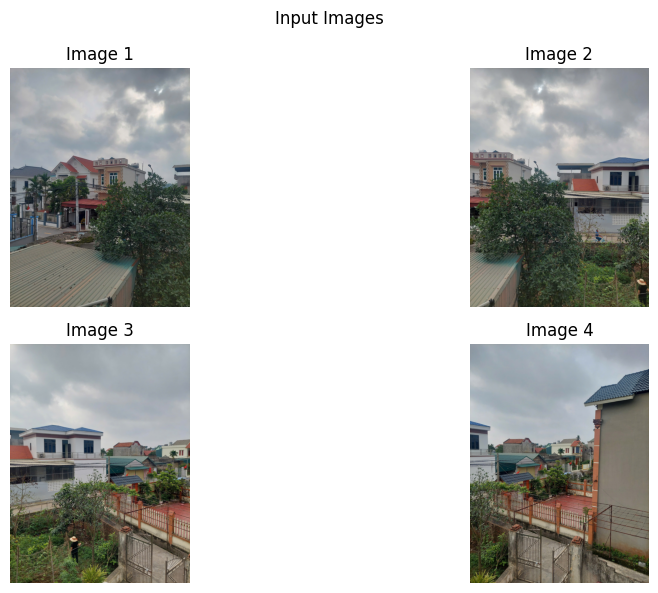

Image 1: Detected 3859 keypoints
Image 2: Detected 5217 keypoints
Image 3: Detected 5903 keypoints
Image 4: Detected 4821 keypoints


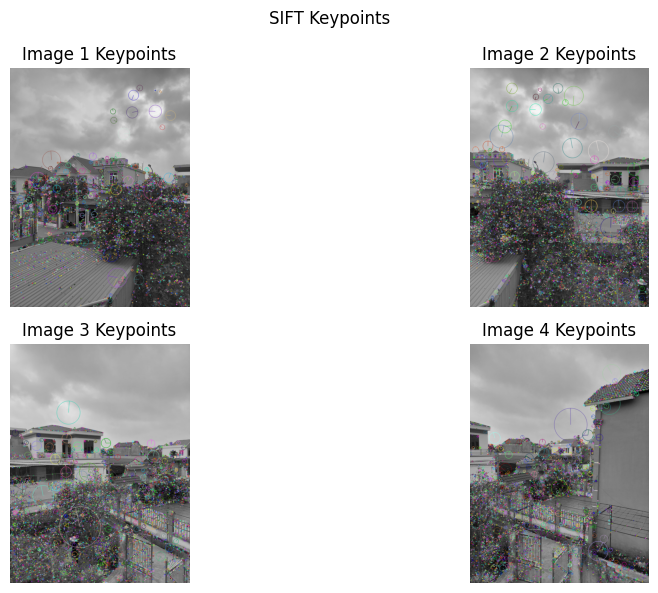

Image 1 to Image 2: 452 good matches
Image 2 to Image 3: 388 good matches
Image 3 to Image 4: 981 good matches


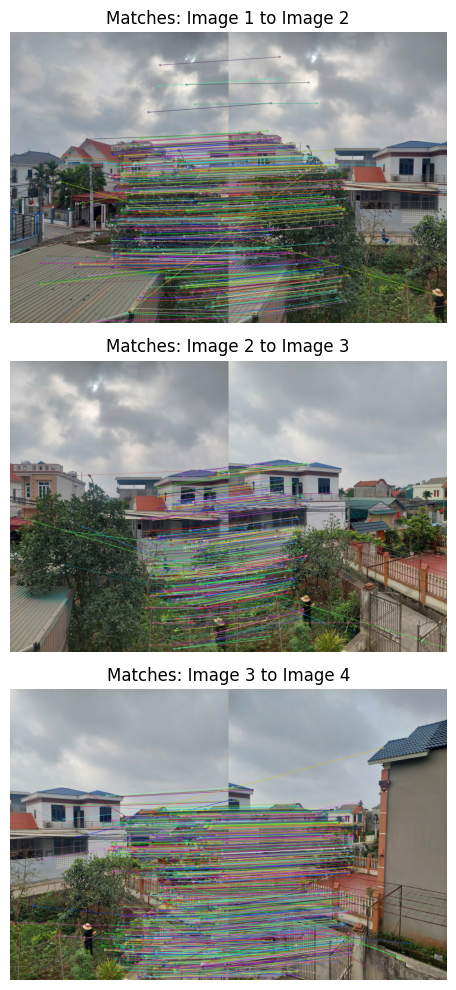

Image 1 to Image 2: 384 inliers out of 452 matches
Image 2 to Image 3: 300 inliers out of 388 matches
Image 3 to Image 4: 884 inliers out of 981 matches


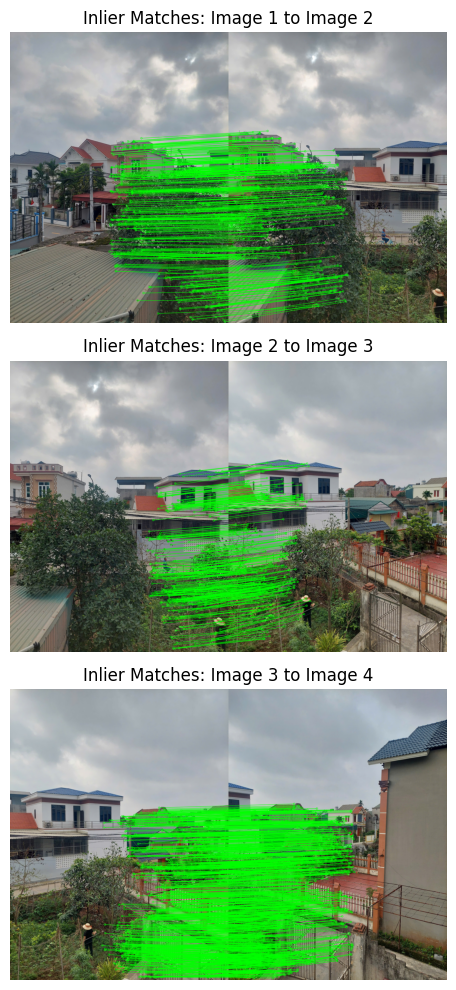

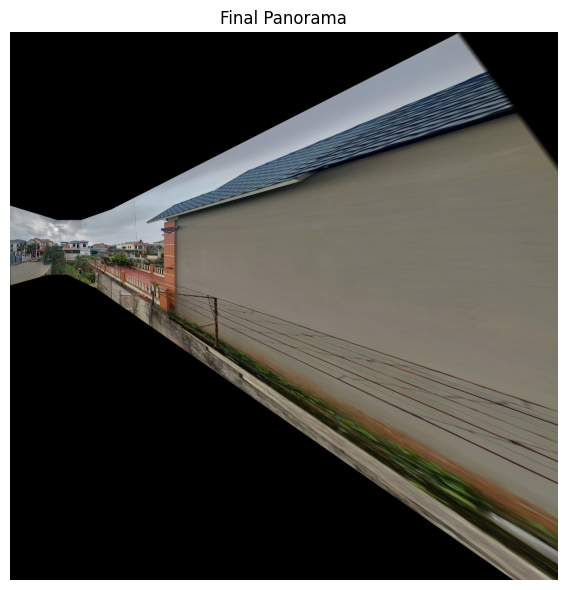

All outputs generated successfully. Check saved PNG files for report.


In [7]:
# Main execution
try:
    # Load and resize images
    images, gray_images = load_images(max_size=1000)
    
    # SIFT feature detection
    keypoints_list, descriptors_list = detect_sift_features(gray_images)
    
    # Feature matching
    matches_list = match_features(keypoints_list, descriptors_list)
    
    # Homography estimation
    homographies, inlier_masks = estimate_homography(keypoints_list, matches_list)
    
    # Warping and blending
    panorama = warp_and_blend_images(images, homographies)
    
    print("All outputs generated successfully. Check saved PNG files for report.")
except Exception as e:
    print(f"Error: {str(e)}")

ORB + RANSAC

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

class PanoramaStitcher:
    def __init__(self, max_size: int = 1000, nfeatures: int = 500, ratio_threshold: float = 0.75):
        self.max_size = max_size
        self.nfeatures = nfeatures
        self.ratio_threshold = ratio_threshold
        self.images = []
        self.gray_images = []
        self.keypoints = []
        self.descriptors = []
        self.matches = []
        self.homographies = []
        self.inlier_masks = []

    def load_images(self, image_paths: List[str]) -> None:
        """Load and resize input images."""
        self.images = []
        for path in image_paths:
            img = cv2.imread(path)
            if img is None:
                raise ValueError(f"Failed to load image: {path}")
            
            # Resize while maintaining aspect ratio
            h, w = img.shape[:2]
            scale = min(self.max_size / w, self.max_size / h, 1.0)
            if scale < 1.0:
                img = cv2.resize(img, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
            self.images.append(img)
        
        self.gray_images = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in self.images]
        self._visualize_inputs()

    def detect_features(self) -> None:
        """Detect ORB features and descriptors."""
        orb = cv2.ORB_create(nfeatures=self.nfeatures)
        self.keypoints = []
        self.descriptors = []
        
        for gray_img in self.gray_images:
            kp, desc = orb.detectAndCompute(gray_img, None)
            self.keypoints.append(kp)
            self.descriptors.append(desc)
        
        self._visualize_keypoints()

    def match_features(self) -> None:
        """Match features between consecutive images."""
        if len(self.descriptors) < 2:
            raise ValueError("Need at least 2 images for matching")
            
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
        self.matches = []
        
        for i in range(len(self.descriptors)-1):
            if self.descriptors[i] is None or self.descriptors[i+1] is None:
                self.matches.append([])
                continue
                
            raw_matches = matcher.knnMatch(self.descriptors[i], self.descriptors[i+1], k=2)
            good_matches = [m for m, n in raw_matches if m.distance < self.ratio_threshold * n.distance]
            self.matches.append(good_matches)
        
        self._visualize_matches()

    def estimate_homographies(self, ransac_thresh: float = 5.0) -> None:
        """Estimate homographies between image pairs."""
        self.homographies = []
        self.inlier_masks = []
        
        for i, matches in enumerate(self.matches):
            if len(matches) < 4:
                print(f"Warning: Insufficient matches ({len(matches)}) between images {i+1} and {i+2}")
                self.homographies.append(None)
                self.inlier_masks.append(None)
                continue
                
            src_pts = np.float32([self.keypoints[i][m.queryIdx].pt for m in matches]).reshape(-1,1,2)
            dst_pts = np.float32([self.keypoints[i+1][m.trainIdx].pt for m in matches]).reshape(-1,1,2)
            
            H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, ransac_thresh)
            if H is None:
                print(f"Warning: Homography estimation failed between images {i+1} and {i+2}")
                self.homographies.append(None)
                self.inlier_masks.append(None)
            else:
                self.homographies.append(H)
                self.inlier_masks.append(mask.ravel().tolist())
        
        self._visualize_inliers()

    def create_panorama(self, reference_idx: int = 1, max_canvas_size: int = 10000) -> np.ndarray:
        """Create panorama by warping and blending images."""
        if not self.homographies:
            raise ValueError("No homographies available for warping")
            
        # Validate homographies
        valid_homographies = [H for H in self.homographies if H is not None]
        if len(valid_homographies) < len(self.images)-1:
            print("Warning: Some homographies are invalid - panorama quality may be affected")
        
        # Compute warped corners for all images
        h, w = self.images[reference_idx].shape[:2]
        corners = []
        valid_indices = []
        
        for i in range(len(self.images)):
            H = self._compute_combined_homography(i, reference_idx)
            if H is None:
                corners.append(None)
                continue
                
            corners_i = np.float32([[0,0], [0,h], [w,h], [w,0]]).reshape(-1,1,2)
            warped_corners = cv2.perspectiveTransform(corners_i, H)
            corners.append(warped_corners)
            valid_indices.append(i)
        
        # Calculate panorama dimensions
        panorama_size, translation, scale = self._calculate_panorama_size(corners, max_canvas_size)
        
        # Warp all valid images
        warped_images = []
        for i in valid_indices:
            H = self._compute_combined_homography(i, reference_idx)
            H = np.dot(translation, H)
            
            warped_img = cv2.warpPerspective(
                self.images[i], H, panorama_size, flags=cv2.INTER_LINEAR
            )
            warped_images.append(warped_img)
        
        # Blend images
        panorama = self._blend_images(warped_images)
        self._visualize_panorama(panorama)
        return panorama

    # Helper methods
    def _compute_combined_homography(self, current_idx: int, reference_idx: int) -> Optional[np.ndarray]:
        """Compute combined homography from current image to reference image."""
        H = np.eye(3)
        
        if current_idx < reference_idx:
            for j in range(current_idx, reference_idx):
                if self.homographies[j] is None:
                    return None
                H = np.dot(self.homographies[j], H)
        elif current_idx > reference_idx:
            for j in range(reference_idx, current_idx):
                if self.homographies[j] is None:
                    return None
                H = np.dot(np.linalg.inv(self.homographies[j]), H)
        
        return H

    def _calculate_panorama_size(self, corners: List, max_size: int) -> Tuple[Tuple[int, int], np.ndarray, float]:
        """Calculate panorama size and required transformations."""
        valid_corners = [c for c in corners if c is not None]
        if not valid_corners:
            raise ValueError("No valid images available for panorama creation")
            
        all_corners = np.concatenate(valid_corners, axis=0)
        x_min, y_min = np.int32(all_corners.min(axis=0).ravel())
        x_max, y_max = np.int32(all_corners.max(axis=0).ravel())
        
        panorama_width = x_max - x_min
        panorama_height = y_max - y_min
        
        # Base translation
        translation = np.array([[1, 0, -x_min], [0, 1, -y_min], [0, 0, 1]], dtype=np.float32)
        
        # Apply scaling if needed
        scale = min(max_size/panorama_width, max_size/panorama_height, 1.0)
        if scale < 1.0:
            scale_matrix = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, 1]])
            translation = np.dot(scale_matrix, translation)
            panorama_width = int(panorama_width * scale)
            panorama_height = int(panorama_height * scale)
        
        return (panorama_width, panorama_height), translation, scale

    def _blend_images(self, warped_images: List[np.ndarray]) -> np.ndarray:
        """Blend warped images using weighted averaging."""
        panorama = np.zeros((*warped_images[0].shape[:2], 3), dtype=np.float32)
        weight_sum = np.zeros(warped_images[0].shape[:2], dtype=np.float32)
        
        for img in warped_images:
            mask = (np.sum(img, axis=2) > 0).astype(np.float32)
            panorama += img * mask[:,:,np.newaxis]
            weight_sum += mask
        
        # Avoid division by zero
        weight_sum[weight_sum == 0] = 1
        panorama /= weight_sum[:,:,np.newaxis]
        
        return np.clip(panorama, 0, 255).astype(np.uint8)

    # Visualization methods
    def _visualize_inputs(self) -> None:
        plt.figure(figsize=(12, 6))
        for i, img in enumerate(self.images, 1):
            plt.subplot(2, 2, i)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.title(f'Image {i}')
            plt.axis('off')
        plt.suptitle('Input Images')
        plt.tight_layout()
        plt.savefig('input_images.png')
        plt.close()

    def _visualize_keypoints(self) -> None:
        keypoint_images = []
        for i, (img, kp) in enumerate(zip(self.gray_images, self.keypoints)):
            kp_img = cv2.drawKeypoints(
                img, kp, None, 
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
            keypoint_images.append(kp_img)
            print(f"Image {i+1}: {len(kp)} keypoints detected")
        
        plt.figure(figsize=(12, 6))
        for i, img in enumerate(keypoint_images, 1):
            plt.subplot(2, 2, i)
            plt.imshow(img, cmap='gray')
            plt.title(f'Image {i} Keypoints')
            plt.axis('off')
        plt.suptitle('Detected Keypoints')
        plt.tight_layout()
        plt.savefig('keypoints.png')
        plt.close()

    def _visualize_matches(self) -> None:
        plt.figure(figsize=(15, 10))
        for i, matches in enumerate(self.matches, 1):
            match_img = cv2.drawMatches(
                self.images[i-1], self.keypoints[i-1],
                self.images[i], self.keypoints[i],
                matches, None,
                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            plt.subplot(len(self.matches), 1, i)
            plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Matches: Image {i} to Image {i+1}')
            plt.axis('off')
            print(f"Image {i} to Image {i+1}: {len(matches)} matches")
        plt.tight_layout()
        plt.savefig('matches.png')
        plt.close()

    def _visualize_inliers(self) -> None:
        plt.figure(figsize=(15, 10))
        for i, (matches, mask) in enumerate(zip(self.matches, self.inlier_masks), 1):
            if mask is None:
                continue
            inliers = [m for j, m in enumerate(matches) if mask[j]]
            match_img = cv2.drawMatches(
                self.images[i-1], self.keypoints[i-1],
                self.images[i], self.keypoints[i],
                inliers, None,
                matchColor=(0,255,0),
                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            plt.subplot(len(self.matches), 1, i)
            plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
            plt.title(f'Inliers: Image {i} to Image {i+1} ({len(inliers)}/{len(matches)})')
            plt.axis('off')
        plt.tight_layout()
        plt.savefig('inliers.png')
        plt.close()

    def _visualize_panorama(self, panorama: np.ndarray) -> None:
        plt.figure(figsize=(12, 6))
        plt.imshow(cv2.cvtColor(panorama, cv2.COLOR_BGR2RGB))
        plt.title('Final Panorama')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('panorama.png')
        plt.close()


if __name__ == "__main__":
    try:
        # Configuration
        image_paths = [
            r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im1.jpg',
            r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im2.jpg',
            r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im3.jpg',
            r'D:\University\Computer_vision\CV\Midterm\data\input\part_c\im4.jpg'
        ]
        
        # Create and run stitcher
        stitcher = PanoramaStitcher(max_size=1000, nfeatures=500, ratio_threshold=0.75)
        stitcher.load_images(image_paths)
        stitcher.detect_features()
        stitcher.match_features()
        stitcher.estimate_homographies(ransac_thresh=5.0)
        panorama = stitcher.create_panorama(reference_idx=1)
        
        print("Panorama stitching completed successfully!")
    except Exception as e:
        print(f"Error during panorama stitching: {str(e)}")
        plt.close('all')

Image 1: 500 keypoints detected
Image 2: 500 keypoints detected
Image 3: 500 keypoints detected
Image 4: 500 keypoints detected
Image 1 to Image 2: 91 matches
Image 2 to Image 3: 16 matches
Image 3 to Image 4: 82 matches
Panorama stitching completed successfully!
